In [1]:
from sklearn import datasets, linear_model, metrics, preprocessing, svm
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from math import e
import pandas as pd

In [2]:
##### ustawienia
time_multiplicator = 5
seed = 244810
#samples = 2410
samples = 620

In [3]:
X, y  = datasets.make_classification(n_features=2,n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2 )

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = (arr[:,col] - xmin )/(xmax-xmin)
    
    return arr        
    
X_train = normalize(X_train)
X_test = normalize(X_test)

#X_train = standarize(X_train)
#X_test = standarize(X_test)

In [6]:
y_train[y_train == 0] =-1
y_test[y_test == 0] =-1

In [7]:
class mysvm:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self.polynomial
            self.degree = degree
        if kernel == 'linear':
            self.kernel = self.polynomial
            self.degree = 1
            
        else:
            self.kernel = self.rbf
            self.sigma = sigma
            
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None
    
    def rbf(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def polynomial(self, X1, X2):
        return (1 + X1.dot(X2.T)) ** self.degree
    
    def fit(self, X, y, lr=2e-4, epochs=500):
        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        #self.alpha = np.ones(X.shape[0])
        self.b = 0
        
        self.ones = np.ones(X.shape[0])

        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
    
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            loss = np.sum(self.alpha) + 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]

        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))

        self.b = np.mean(b_i)

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b
    
    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')

        plt.show()


In [8]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te ):
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    #graph
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    
    #confusion matrix
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0] ,cmap='plasma')
    sk_disp.im_.colorbar.remove()

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1] ,cmap='plasma')
    my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')

    #roc
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my._decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    #metryki
    print('              | Sklearn | Własna')
    print('--------------+---------+----------')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')      
        
    
    

### Porównanie modeli liniowych

In [9]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)
mc_train[mc_train == 0] =-1
mc_test[mc_test == 0] =-1
M_train = normalize(M_train)
M_test = normalize(M_test)


              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|1.0000
Specyficzność |   0.4380|0.4380
Skuteczność   |   0.9758|0.9758
Czas wykonania| 1.58E-03|8.56E-01


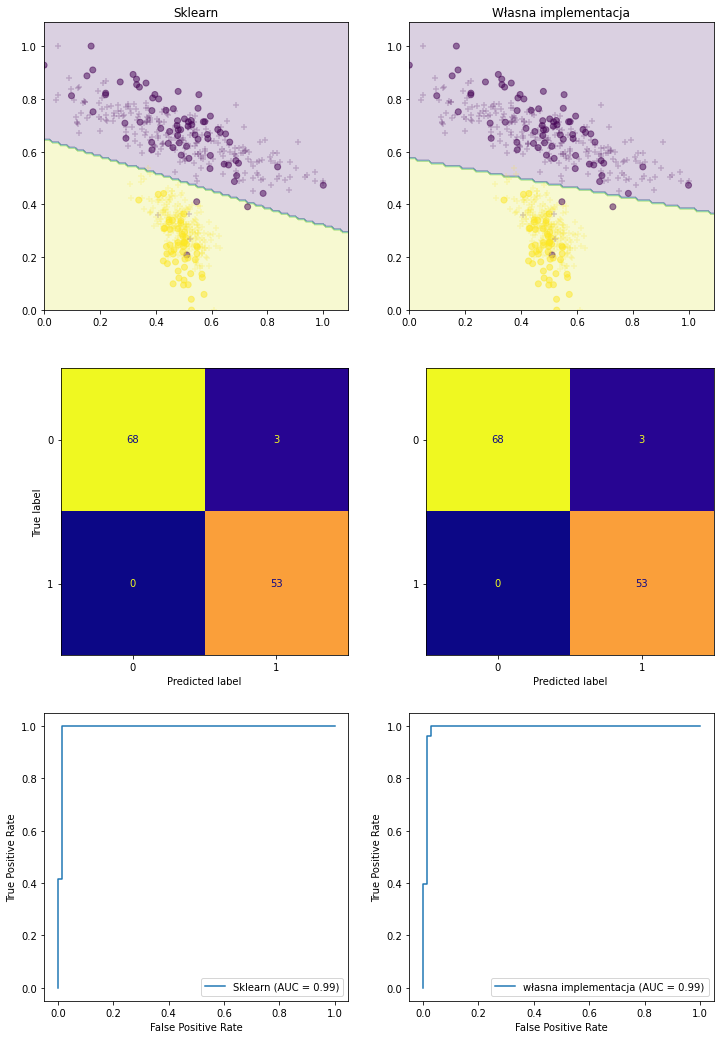

In [10]:
my11 = mysvm(kernel='linear', C=0.7)
sk11 = svm.SVC(kernel='linear')
compare_model(sk11, my11,X_train, X_test, y_train, y_test)

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9474|0.9464
Specyficzność |   0.5263|0.5310
Skuteczność   |   0.5323|0.5242
Czas wykonania| 2.72E-03|7.43E-01


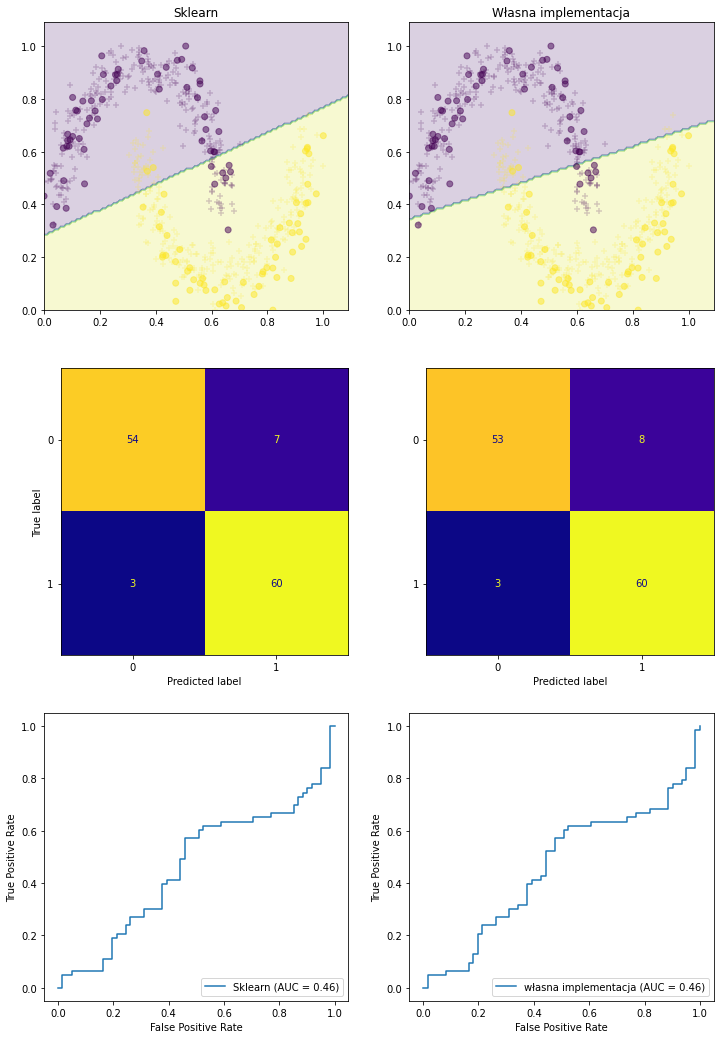

In [11]:
my12 = mysvm(kernel='linear', C=0.7)
sk12 = svm.SVC(kernel='linear')
compare_model(sk12, my12,M_train, M_test, mc_train, mc_test)

### Porównanie modeli RBF

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|1.0000
Specyficzność |   0.4344|0.4417
Skuteczność   |   0.9839|0.9677
Czas wykonania| 1.30E-03|6.69E-01


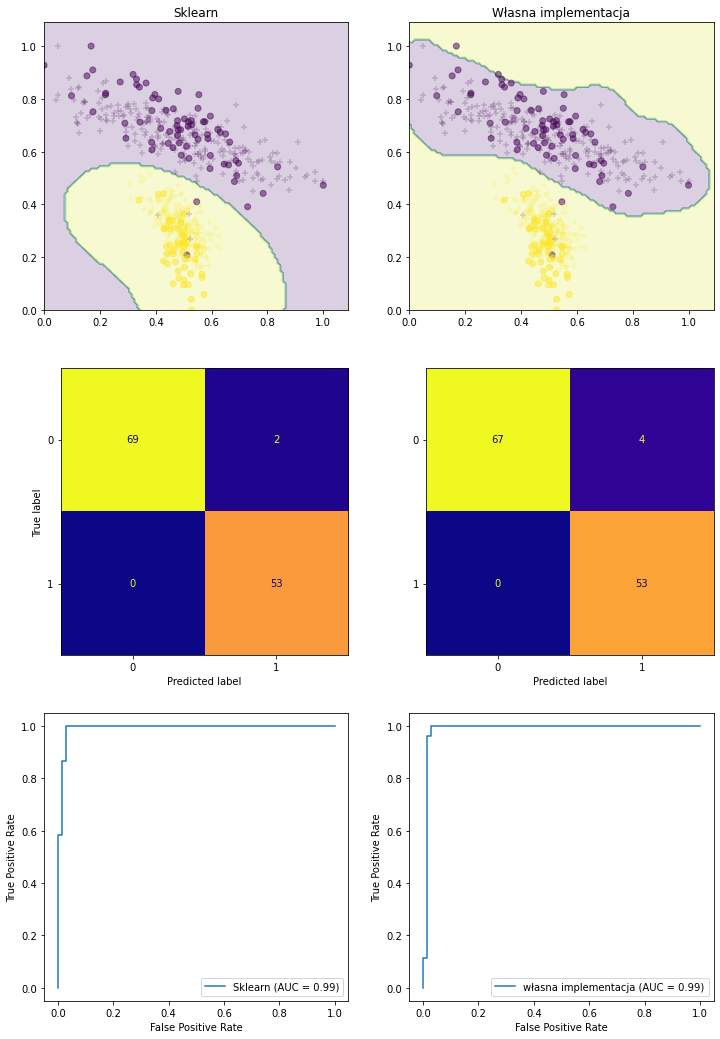

In [12]:
my21 = mysvm(kernel='rbf', C=0.7)
sk21 = svm.SVC(kernel='rbf')
compare_model(sk21, my21,X_train, X_test, y_train, y_test)

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9836|0.9836
Specyficzność |   0.5082|0.5082
Skuteczność   |   0.5323|0.5323
Czas wykonania| 1.90E-03|7.58E-01


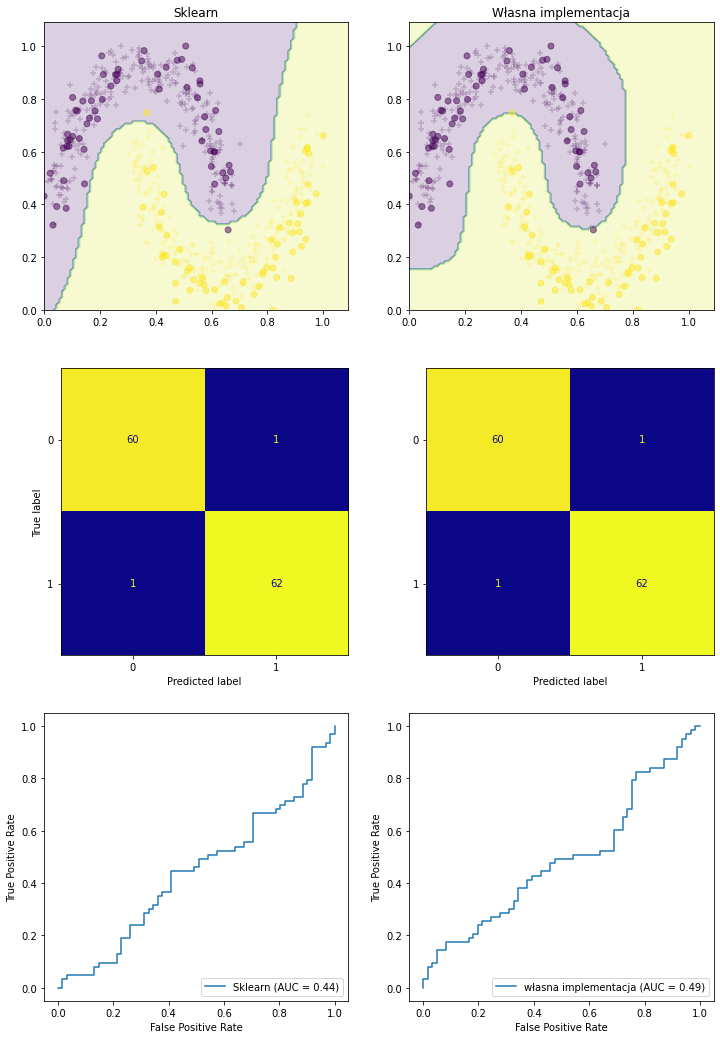

In [13]:
my22 = mysvm(kernel='rbf', C=0.7)
sk22 = svm.SVC(kernel='rbf')

compare_model(sk22, my22,M_train, M_test, mc_train, mc_test)

### Porównanie modeli wielomianowych 3 stopnia

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|1.0000
Specyficzność |   0.4344|0.4454
Skuteczność   |   0.9839|0.9597
Czas wykonania| 2.56E-03|8.25E-01


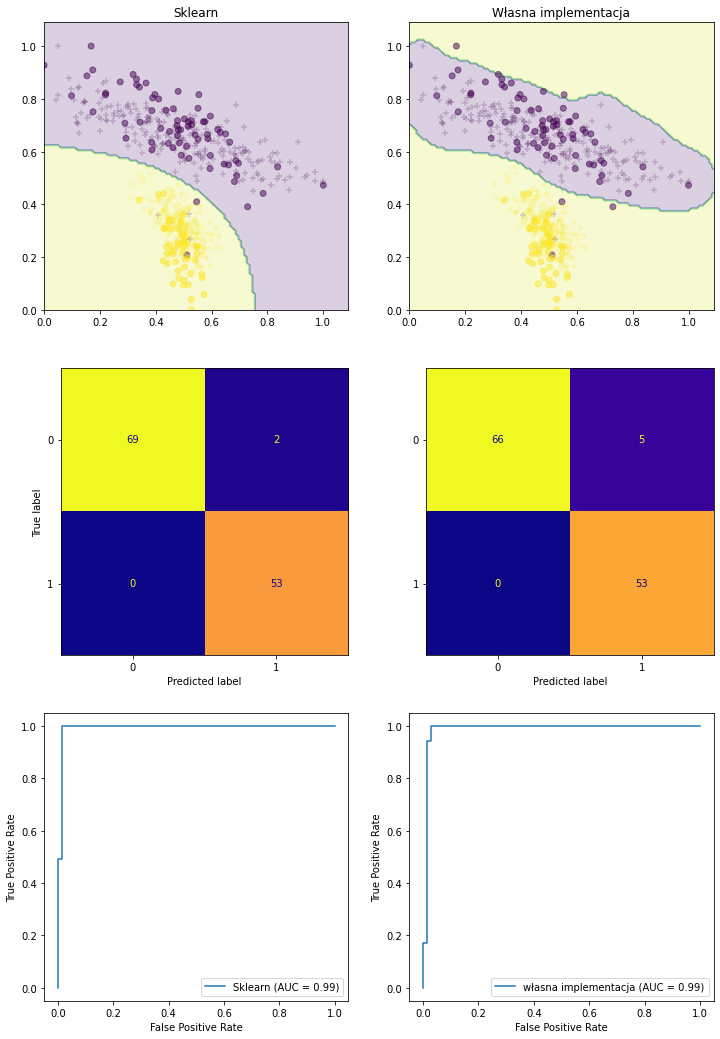

In [14]:
my31 = mysvm(kernel='poly', degree=1)
sk31 = svm.SVC(kernel='poly', degree=3)
compare_model(sk31, my31,X_train, X_test, y_train, y_test)

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9167|0.9836
Specyficzność |   0.5133|0.5082
Skuteczność   |   0.5081|0.5323
Czas wykonania| 8.01E-03|7.50E-01


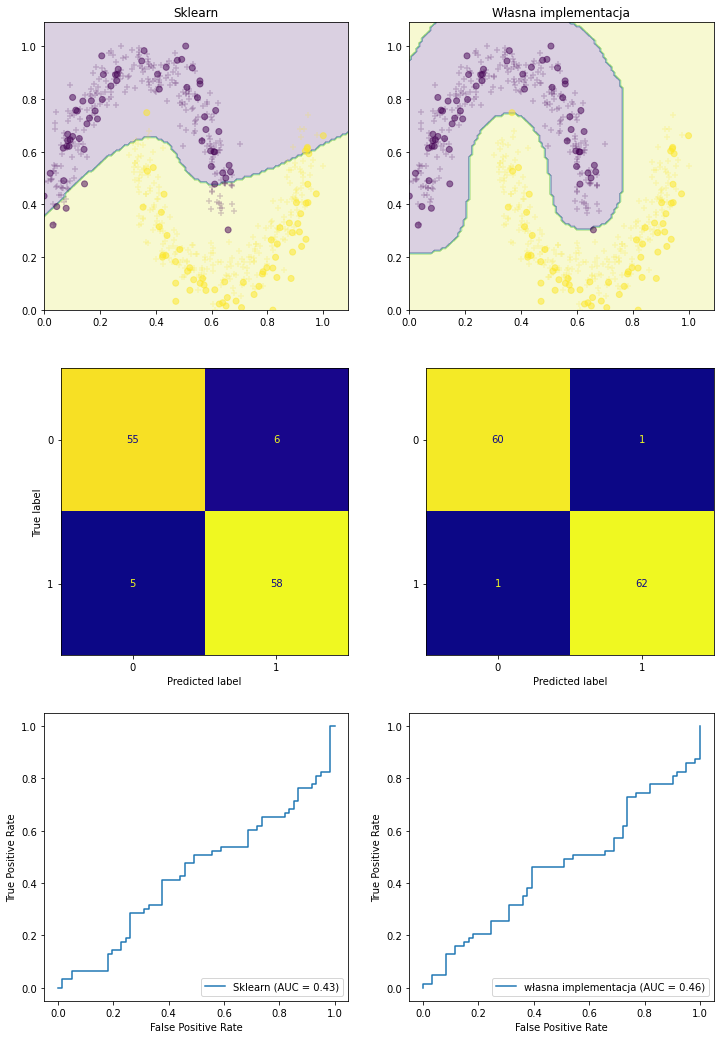

In [15]:
my32 = mysvm(kernel='poly', degree=3)
sk32 = svm.SVC(kernel='poly', degree=3)
compare_model(sk32, my32,M_train, M_test, mc_train, mc_test)